# Marketing Campaign Modeling & Advanced Analysis

## 1. Import Libraries

In [3]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import shap
import scipy.stats as stats


## 2. Load and Clean Data

In [6]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.columns = df.columns.str.strip()
df['Age'] = 2014 - df['Year_Birth']
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,3,11,1,57
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,3,11,0,60
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,3,11,0,49
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,3,11,0,30
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,3,11,0,33


## 3. Define Features and Target

In [8]:
features = df.drop(columns=['Response'])
target = df['Response']
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns


## 4. Preprocessing Pipelines

In [10]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


## 5. Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)


## 6. Model Training (Logistic Regression and Random Forest)

In [14]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
logreg_pipeline.fit(X_train, y_train)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatal...
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Age'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

## 7. Evaluation

In [16]:
logreg_preds = logreg_pipeline.predict(X_test)
rf_preds = rf_pipeline.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, logreg_preds))
print("Random Forest:")
print(classification_report(y_test, rf_preds))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       577
           1       0.67      0.40      0.50        95

    accuracy                           0.89       672
   macro avg       0.79      0.68      0.72       672
weighted avg       0.87      0.89      0.87       672

Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       577
           1       0.68      0.18      0.28        95

    accuracy                           0.87       672
   macro avg       0.78      0.58      0.61       672
weighted avg       0.85      0.87      0.84       672



## 8. Confusion Matrix

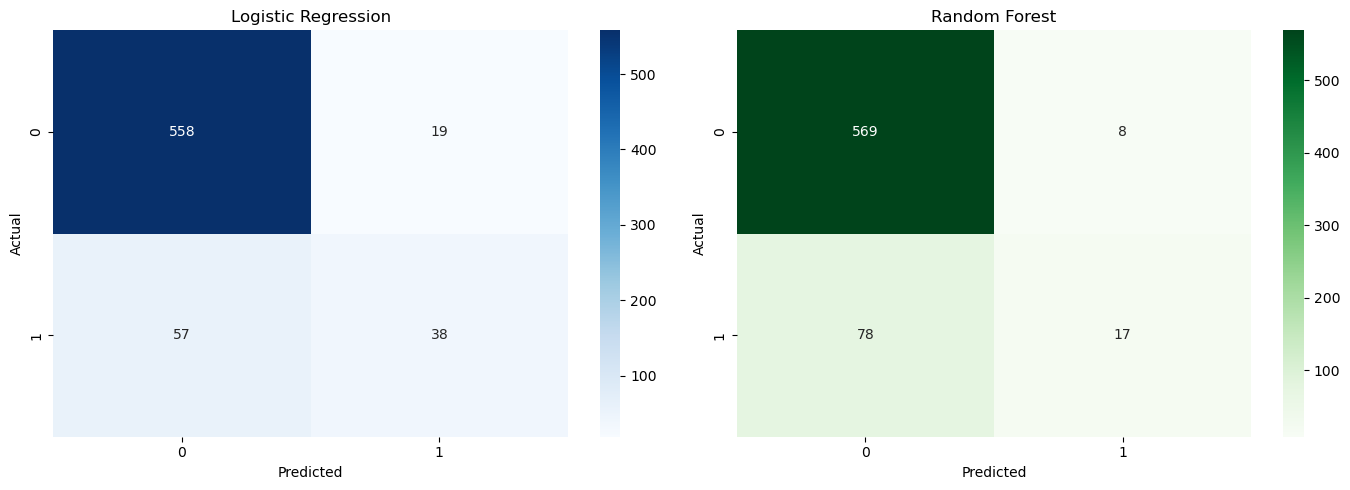

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, logreg_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()


## 9. ROC Curve

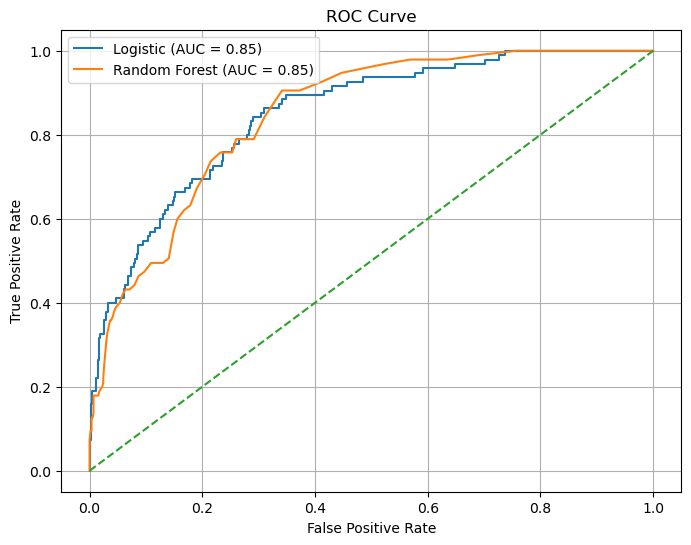

In [20]:
logreg_probs = logreg_pipeline.predict_proba(X_test)[:, 1]
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {auc(fpr_log, tpr_log):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()


## 10. Feature Importance (Random Forest)

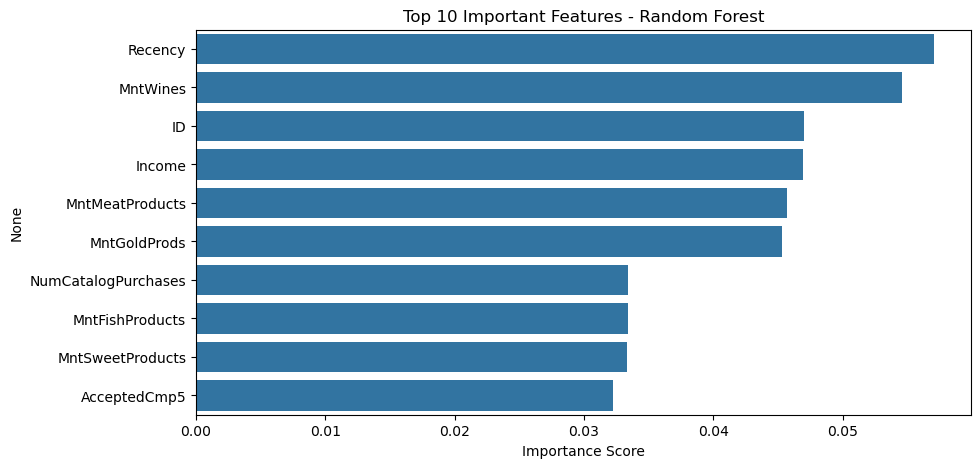

In [22]:
rf_model = rf_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_
ohe_features = rf_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(ohe_features)
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.show()


## 11. L1 and L2 Regularized Logistic Regression

In [24]:
log_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, max_iter=1000)
log_l2 = LogisticRegressionCV(penalty='l2', solver='liblinear', cv=5, max_iter=1000)

l1_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', log_l1)])
l2_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', log_l2)])

l1_pipeline.fit(X_train, y_train)
l2_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatal...
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Age'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Education', 'Marital_Status', 'Dt_Customer'], dtype='object'))])),
                ('classifier',
                 LogisticRegressionCV(cv=5, max_iter=1000,
                                      solver='liblinear'))])

## 12. SHAP Values

<Figure size 640x480 with 0 Axes>

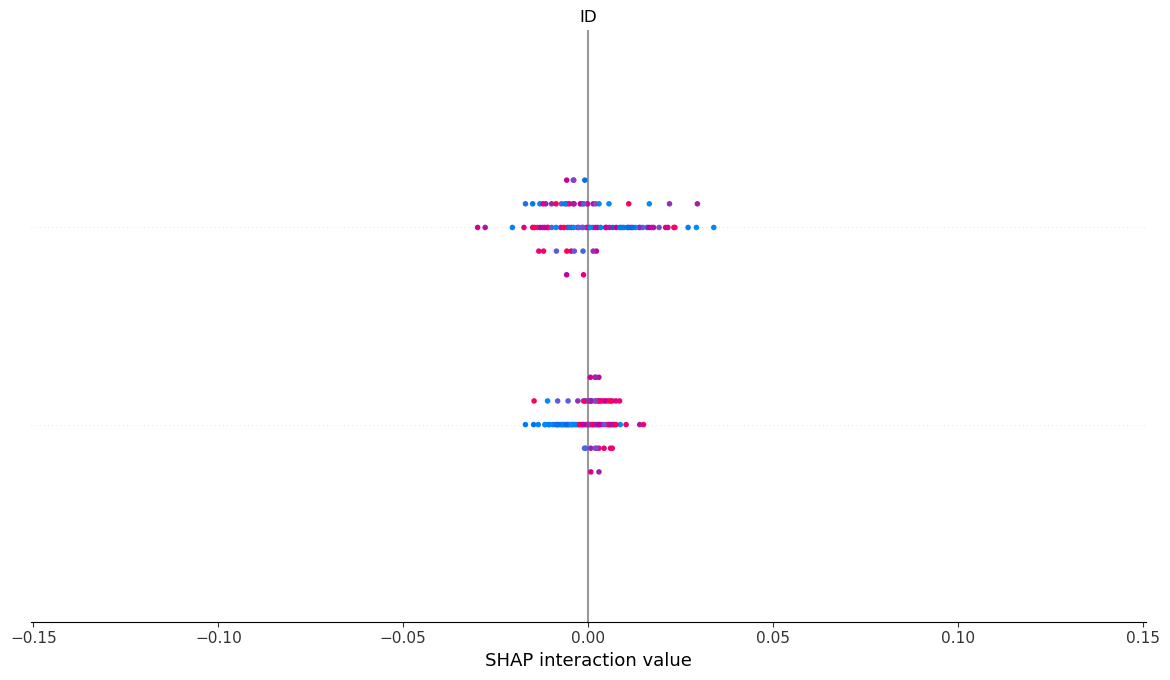

SHAP shape: (100, 2)
X_transformed shape: (100, 658)
Feature names length: 658


In [26]:
# Transform test data using the preprocessing pipeline
X_transformed = preprocessor.transform(X_test)

# Convert to dense array if OneHotEncoder output is sparse
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# Rebuild the full feature names after encoding
preprocessor.fit(X_train)  # Fit explicitly to extract names
categorical_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
encoded_cat_names = categorical_encoder.get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(encoded_cat_names)

# Compute SHAP values for the random forest
rf_model = rf_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_transformed)

# If binary classification, use shap_values[1]; otherwise use shap_values
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values

# Fix shape mismatch by slicing if necessary
if shap_vals.shape[1] > X_transformed.shape[1]:
    shap_vals = shap_vals[:, :X_transformed.shape[1]]

# Plot SHAP summary (limit to 100 rows for performance)
shap.summary_plot(shap_vals[:100], X_transformed[:100], feature_names=all_features)
# Check shapes
print("SHAP shape:", shap_values[1][:100].shape)
print("X_transformed shape:", X_transformed[:100].shape)
print("Feature names length:", len(all_features))


## 13. A/B Testing for Segment Performance

In [28]:
df['Age_Group'] = df['Age'].apply(lambda x: 'Under_40' if x < 40 else '40_and_above')
group_a = df[df['Age_Group'] == 'Under_40']['Response']
group_b = df[df['Age_Group'] == '40_and_above']['Response']
t_stat, p_value = stats.ttest_ind(group_a, group_b)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference.")
else:
    print("No significant difference.")


T-statistic: 0.4975, P-value: 0.6189
No significant difference.


T-statistic: 6.7572, P-value: 0.0000
Statistically significant difference in response rates between income groups.

Response Rates:
High Income Group: 21.52%
Low Income Group:  11.05%


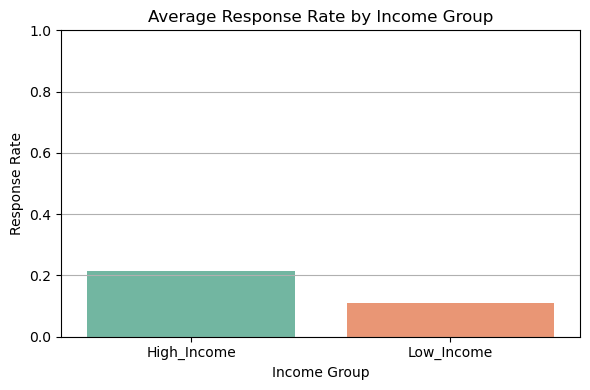

In [29]:
# Drop missing income rows and copy the DataFrame to avoid SettingWithCopyWarning
df_income = df.dropna(subset=['Income']).copy()

# Create High and Low income groups
df_income['Income_Group'] = df_income['Income'].apply(lambda x: 'High_Income' if x > 60000 else 'Low_Income')

# Separate response data for each group
group_high = df_income[df_income['Income_Group'] == 'High_Income']['Response']
group_low = df_income[df_income['Income_Group'] == 'Low_Income']['Response']

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(group_high, group_low)

# Print test results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Statistically significant difference in response rates between income groups.")
else:
    print("No significant difference in response rates between income groups.")

# Print actual response rates
print("\nResponse Rates:")
print(f"High Income Group: {group_high.mean():.2%}")
print(f"Low Income Group:  {group_low.mean():.2%}")

# Compute mean response rate for each income group
mean_response_rates = df_income.groupby('Income_Group')['Response'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=mean_response_rates, x='Income_Group', y='Response', hue='Income_Group', palette='Set2', legend=False)
plt.title('Average Response Rate by Income Group')
plt.ylabel('Response Rate')
plt.xlabel('Income Group')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
